In [1]:
from pathlib import Path

import cv2
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch.utils.data as data
import os

from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("../input/birdsong-recognition/train_32000.csv")

In [ ]:
idx = ys.argsort()[2]
PERIOD = 6
sample = df.loc[idx, :]
wav_name = sample["resampled_filename"]
ebird_code = sample["ebird_code"]
y, sr = sf.read(os.path.join("../input/train_audio_resampled_32000/",  ebird_code ,  wav_name))

In [ ]:
len_y = len(y)
print(f"len_y {len_y}")
effective_length = sr * PERIOD
if len_y < effective_length:
    new_y = np.zeros(effective_length, dtype=y.dtype)
    start = np.random.randint(effective_length - len_y)
    new_y[start:start + len_y] = y
    y_crop = new_y.astype(np.float32)
elif len_y > effective_length:
    start = np.random.randint(len_y - effective_length)
    y_crop = y[start:start + effective_length].astype(np.float32)
else:
    y_crop = y.astype(np.float32)
print(f"start position {start}, len {len(y_crop)}")
melspec = librosa.feature.melspectrogram(y_crop, sr=sr, **{})
melspec = librosa.power_to_db(melspec).astype(np.float32)
print(f"melspec size {melspec.shape}")
plt.axis('off')
plt.imshow(melspec)

In [ ]:
len_y = len(y)
print(f"len_y {len_y}")
pad = 1000
effective_length = sr * PERIOD
y_crop = np.tile(y[pad :-pad ], (effective_length // (len_y-pad *2) + 1,))
start = np.random.randint(len(y_crop) - effective_length)
y_crop = y_crop[start:start + effective_length].astype(np.float32)
print(f"start position {start}, len {len(y_crop)}")
melspec = librosa.feature.melspectrogram(y_crop, sr=sr, **{})
melspec = librosa.power_to_db(melspec).astype(np.float32)
print(f"melspec size {melspec.shape}")
plt.axis('off')
plt.imshow(melspec)

In [ ]:
# ys = []

# for idx in tqdm(range(len(df))):
#     sample = df.loc[idx, :]
#     wav_name = sample["resampled_filename"]
#     ebird_code = sample["ebird_code"]
#     y, sr = sf.read(os.path.join("../input/train_audio_resampled_32000/",  ebird_code ,  wav_name))
#     ys.append(len(y))

In [ ]:
print(f"min length {min(ys)} max length {max(ys)} mean length {sum(ys) / len(ys)}")

In [ ]:
df.columns.values

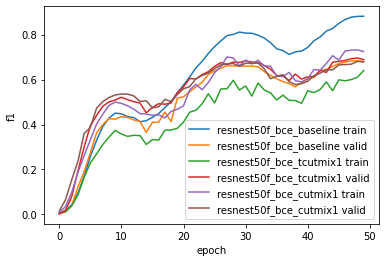

In [29]:
def plot_result(config, column, mode=None):
    if mode == "train":
        train_log = pd.read_csv(f"../logs/{config}/fold0/logs/train_log.csv")
        plt.plot(train_log.epoch.values, getattr(train_log, column).values, label=f"{config} train")
    elif mode == "valid":
        valid_log = pd.read_csv(f"../logs/{config}/fold0/logs/valid_log.csv")
        plt.plot(valid_log.epoch.values, getattr(valid_log, column).values, label=f"{config} valid")
    else:
        train_log = pd.read_csv(f"../logs/{config}/fold0/logs/train_log.csv")
        valid_log = pd.read_csv(f"../logs/{config}/fold0/logs/valid_log.csv")
        plt.plot(train_log.epoch.values, getattr(train_log, column).values, label=f"{config} train")
        plt.plot(valid_log.epoch.values, getattr(valid_log, column).values, label=f"{config} valid")

    plt.xlabel("epoch")
    plt.ylabel(column)
    plt.legend()
plot_result("resnest50f_bce_baseline", "f1")
# plot_result("resnest50f_bce_mixup", "f1", "valid")
# plot_result("resnest50f_bce_cutmix", "f1", "valid")
# plot_result("resnest50f_bce_tcutmix05", "f1")
plot_result("resnest50f_bce_tcutmix1", "f1")
plot_result("resnest50f_bce_cutmix1", "f1")